In [111]:
# implicit_PDE_rod
#
# based on https://github.com/numerical-mooc/numerical-mooc/blob/master/lessons/04_spreadout/04_02_Heat_Equation_1D_Implicit.ipynb

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

# Set parameters.
L = 1.0  # length of the rod
nx = 101  # number of locations on the rod
dx = L / (nx - 1)  # distance between two consecutive locations
alpha = 1  #  thermal diffusivity of the rod

# Define the locations along the rod.
x = np.linspace(0.0, L, num=nx)

def lhs_operator(N, sigma):
    """
    Computes and returns the implicit operator
    of the system for the 1D diffusion equation.
    We use backward Euler method, Dirichlet condition
    on the left side of the domain and zero-gradient
    Neumann condition on the right side.
    
    Parameters
    ----------
    N : integer
        Number of interior points.
    sigma : float
        Value of alpha * dt / dx**2.
    
    Returns
    -------
    A : numpy.ndarray
        The implicit operator as a 2D array of floats
        of size N by N.
    """
    # Setup the diagonal of the operator.
    D = np.diag((2.0 + 1.0 / sigma) * np.ones(N))
    # Setup the Neumann condition for the last element.
    #D[-1, -1] = 1.0 + 1.0 / sigma
    # Setup the upper diagonal of the operator.
    U = np.diag(-1.0 * np.ones(N - 1), k=1)
    # Setup the lower diagonal of the operator.
    L = np.diag(-1.0 * np.ones(N - 1), k=-1)
    # Assemble the operator.
    A = D + U + L
    A[0,0]=1
    A[0,1]=0
    A[-1,-1]=1
    A[-1,-2]=0
    return A


def rhs_vector(T, sigma, left, right):
    """
    Computes and returns the right-hand side of the system
    for the 1D diffusion equation, using a Dirichlet condition
    
    Parameters
    ----------
    T : numpy.ndarray
        The temperature distribution as a 1D array of floats.
    sigma : float
        Value of alpha * dt / dx**2.
    
    Returns
    -------
    b : numpy.ndarray
        The right-hand side of the system as a 1D array of floats.
    """
    b = T / sigma
    # Set Dirichlet condition.
    b[0] = left
    b[-1] = right
    return b

def btcs_implicit(T0, nt, dt, dx, alpha, left, right):
    """
    Computes and returns the temperature along the rod
    after a given number of time steps.
    
    The function uses Euler implicit in time,
    central differencing in space, a Dirichlet condition
    on the left side, and a Neumann condition on the
    right side.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        The initial temperature distribution as a 1D array of floats.
    nt : integer
        Number of time steps to compute.
    dt : float
        Time-step size.
    dx : float
        Distance between two consecutive locations.
    alpha : float
        Thermal diffusivity of the rod.
    
    Returns
    -------
    T : numpy.ndarray
        The temperature distribution as a 1D array of floats.
    """
    sigma = alpha * dt / dx**2
    # Create the implicit operator of the system.
    A = lhs_operator(len(T0), sigma)
    # Integrate in time.
    T = T0.copy()
    output = [[0,T.copy()]]
    for n in range(nt):
        # Generate the right-hand side of the system.
        b = rhs_vector(T, sigma, left, right)
        # Solve the system with scipy.linalg.solve.
        T = linalg.solve(A, b)
        output += [[n+1,T.copy()]]
    return output


In [98]:
lhs_operator(5, 2)

array([[ 1. ,  0. ,  0. ,  0. ,  0. ],
       [-1. ,  2.5, -1. ,  0. ,  0. ],
       [ 0. , -1. ,  2.5, -1. ,  0. ],
       [ 0. ,  0. , -1. ,  2.5, -1. ],
       [ 0. ,  0. ,  0. ,  0. ,  1. ]])

In [127]:
# Set the time-step 
sigma = 5
dt = sigma * dx**2 / alpha  # time-step size
nt = 1001  # number of time steps to compute

# Set the initial temperature along the rod.
T0 = np.zeros(nx)
T0[5:36] = 100.0
T0[35:66] = 50
T0[:6] = 80
T0[65:96] = 0
T0[95:] = 20
#T0[int(nx/2):] = 0
print(T0)

# Compute the temperature along the rod.
T = btcs_implicit(T0, nt, dt, dx, alpha, 80, 20)

[ 80.  80.  80.  80.  80.  80. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100.  50.  50.  50.  50.  50.  50.  50.
  50.  50.  50.  50.  50.  50.  50.  50.  50.  50.  50.  50.  50.  50.
  50.  50.  50.  50.  50.  50.  50.  50.  50.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  20.  20.  20.
  20.  20.  20.]


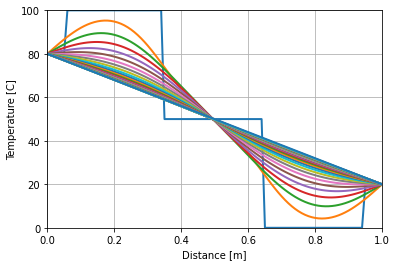

In [128]:
# Plot the temperature along the rod.
plt.figure(figsize=(6.0, 4.0))
plt.xlabel('Distance [m]')
plt.ylabel('Temperature [C]')
plt.grid()
for i,t in [*T[0:300:10],T[-100]]:
  plt.plot(x, t, linestyle='-', linewidth=2)
plt.xlim(0.0, L)
plt.ylim(0.0, 100.0);

In [129]:
OUT = np.matrix([i[1] for i in T])
np.savetxt("solution_heat_1D.txt", OUT)

In [124]:
import numpy as np
T = np.loadtxt('solution_heat_1D.txt')


In [110]:
trange = [0,10,20,30,60,120,240,500]
xrange = [0,20,40,60,80,100]
T[np.ix_(trange,xrange)]

array([[100.        , 100.        ,   0.        ,   0.        ,
         50.        ,  50.        ],
       [ 80.        ,  88.86371263,  22.20844447,  12.95163292,
         44.27626007,  20.        ],
       [ 80.        ,  78.46745535,  30.88585906,  18.45957157,
         37.09170488,  20.        ],
       [ 80.        ,  72.17491823,  35.71480012,  22.49928788,
         32.29164844,  20.        ],
       [ 80.        ,  64.40679081,  42.51608383,  29.44236947,
         26.49180228,  20.        ],
       [ 80.        ,  62.90604839,  46.97632809,  34.62011945,
         26.32783607,  20.        ],
       [ 80.        ,  64.92507841,  50.99429929,  38.9600737 ,
         28.86970002,  20.        ],
       [ 80.        ,  67.13701407,  54.60348726,  42.6032745 ,
         31.13666981,  20.        ]])

In [94]:
T[0,3]

100.0

In [95]:
T[-1]

array([80.        , 79.39997133, 78.79994269, 78.19991411, 77.59988561,
       76.99985723, 76.39982899, 75.79980091, 75.19977303, 74.59974538,
       73.99971798, 73.39969085, 72.79966403, 72.19963754, 71.59961141,
       70.99958567, 70.39956033, 69.79953542, 69.19951098, 68.59948701,
       67.99946356, 67.39944063, 66.79941825, 66.19939645, 65.59937525,
       64.99935466, 64.39933471, 63.79931541, 63.19929679, 62.59927886,
       61.99926165, 61.39924516, 60.79922942, 60.19921444, 59.59920024,
       58.99918682, 58.39917421, 57.79916241, 57.19915144, 56.5991413 ,
       55.99913202, 55.39912359, 54.79911602, 54.19910933, 53.59910351,
       52.99909859, 52.39909455, 51.7990914 , 51.19908915, 50.5990878 ,
       49.99908735, 49.3990878 , 48.79908915, 48.1990914 , 47.59909455,
       46.99909859, 46.39910351, 45.79910933, 45.19911602, 44.59912359,
       43.99913202, 43.3991413 , 42.79915144, 42.19916241, 41.59917421,
       40.99918682, 40.39920024, 39.79921444, 39.19922942, 38.59

In [96]:
np.gradient(T[-1])

array([-0.60002867, -0.60002865, -0.60002861, -0.60002854, -0.60002844,
       -0.60002831, -0.60002816, -0.60002798, -0.60002777, -0.60002753,
       -0.60002726, -0.60002697, -0.60002665, -0.60002631, -0.60002594,
       -0.60002554, -0.60002512, -0.60002467, -0.6000242 , -0.60002371,
       -0.60002319, -0.60002265, -0.60002209, -0.6000215 , -0.6000209 ,
       -0.60002027, -0.60001962, -0.60001896, -0.60001827, -0.60001757,
       -0.60001685, -0.60001611, -0.60001536, -0.60001459, -0.60001381,
       -0.60001301, -0.60001221, -0.60001139, -0.60001055, -0.60000971,
       -0.60000886, -0.600008  , -0.60000713, -0.60000625, -0.60000537,
       -0.60000448, -0.60000359, -0.6000027 , -0.6000018 , -0.6000009 ,
       -0.6       , -0.5999991 , -0.5999982 , -0.5999973 , -0.59999641,
       -0.59999552, -0.59999463, -0.59999375, -0.59999287, -0.599992  ,
       -0.59999114, -0.59999029, -0.59998945, -0.59998861, -0.59998779,
       -0.59998699, -0.59998619, -0.59998541, -0.59998464, -0.59

In [83]:
60/101

0.594059405940594

In [56]:
x

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [60]:
np.gradient(y,x)

array([-60., -60., -60., -60., -60., -60., -60., -60., -60., -60., -60.])

In [61]:
T[-1]

array([79.41172563, 78.8234513 , 78.23517704, 77.6469029 , 77.0586289 ,
       76.47035508, 75.88208149, 75.29380816, 74.70553511, 74.1172624 ,
       73.52899006, 72.94071811, 72.3524466 , 71.76417555, 71.17590501,
       70.58763501, 69.99936557, 69.41109674, 68.82282854, 68.23456101,
       67.64629417, 67.05802806, 66.4697627 , 65.88149812, 65.29323436,
       64.70497143, 64.11670937, 63.52844819, 62.94018793, 62.35192861,
       61.76367025, 61.17541287, 60.58715649, 59.99890114, 59.41064683,
       58.82239358, 58.23414141, 57.64589033, 57.05764036, 56.46939151,
       55.8811438 , 55.29289723, 54.70465182, 54.11640758, 53.52816452,
       52.93992263, 52.35168194, 51.76344244, 51.17520414, 50.58696704,
       49.99873115, 49.41049646, 48.82226297, 48.23403068, 47.64579959,
       47.05756969, 46.46934099, 45.88111346, 45.29288712, 44.70466194,
       44.11643792, 43.52821504, 42.9399933 , 42.35177268, 41.76355317,
       41.17533476, 40.58711742, 39.99890114, 39.41068591, 38.82

In [62]:
x

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]